# Credit Risk Modeling

How do financial firms make a decision on applications for credit cards or loans? In this project I will explore how to apply machine learning techniques to reduce risk and ensure profitability. I will use data sets that emulate real credit applications while focusing on business value.


## Understanding Credit Risk

What is credit risk?

- The possibility that someone who has borrowed money will not repay it all
- When someone fails to repay a loan, it is said to be in default
- The likelihood that someone will default on a loan is the probability of default (PD)


Expected loss: the amount a firms loses as a result of loan default. Expected loss is a calculation of 3 primary components:

- Probability of default (PD): likelihood that someone will default on a loan
- Exposure at default (EAD): the amount outstanding at the time of default
- Loss given default (LGD): the ratio of the exposure against any recovery from the loss. For example, if we loan 100 dollars to someone, 100 is our exposure and if we sell that debt for 20 dollars, our loss given default would be 80%. 

The formula for expected loss is:

Expected_Loss = PD * EAD * LGD

I will focus on probability of default. For modeling probability of default we generally have two primary types of data available: 

- Application data: data which is directly tied to the loan application like loan grade, 
- Behavioral data: describes the recipient of the loan,  such as employment length.
                    

## Exploratory Data Analysis

Lets begin exploring the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

cr_loan = pd.read_csv('~/Downloads/cr_loan2.csv')

These are the columns we have in our data set

In [2]:
print(cr_loan.dtypes)

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


In [3]:
print(cr_loan.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


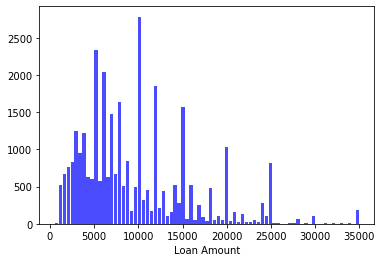

In [4]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

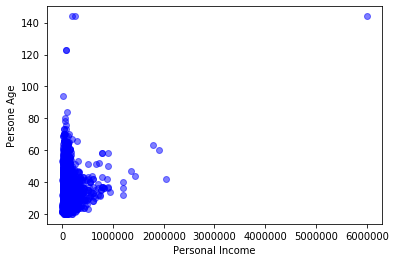

In [5]:
# Plot a scatter plot of income against age
plt.scatter(cr_loan['person_income'], cr_loan['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

### Crosstab and pivot tables

With cross tables, we get a high level view of selected columns and even agreggation like a count or average. For credit risk modeling, columns like person_emp_length and person_home_ownershio are common to begin investigating.

For now, we will check how loan_status is affected by things like home ownership status, loan grade, and loan percentage of income.

In [6]:
# Create a cross table of the loan intent and loan status
print(pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581


In [7]:
# Create a cross table of home ownership, loan status, and grade
print(pd.crosstab(cr_loan['person_home_ownership'],[cr_loan['loan_status'],cr_loan['loan_grade']]))

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27  


In [8]:
# Create a cross table of home ownership, loan status, and average percent income
print(pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
              values=cr_loan['loan_percent_income'], aggfunc='mean'))

loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859


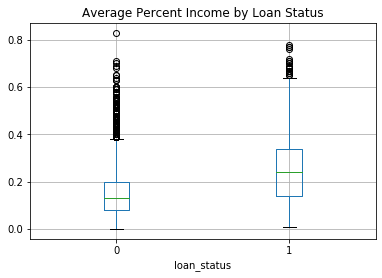

In [9]:
# Create a box plot of percentage income by loan status
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

It looks like the average percentage of income for defaults is higher. This could indicate those recipients have a debt-to-income ratio that's too high.

## Data Processing

It may not be possible for a person to have an employment length of less than 0 or more than 60. Let's check if we have any instances of this

#### Outliers in employment length

In [10]:
# Removing outliers

# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
        values=cr_loan['person_emp_length'], aggfunc='max'))

# Create an array of indices where employment length is greater than 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index

# Drop the records from the data based on the indices and create a new dataframe
cr_loan_new = cr_loan.drop(indices)

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


In [11]:
# Create the cross table from earlier and include minimum employment length
print(pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max']))

                           min                      max                  
person_home_ownership MORTGAGE OTHER  OWN RENT MORTGAGE OTHER   OWN  RENT
loan_status                                                              
0                          0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1                          0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0


#### Outliers in age

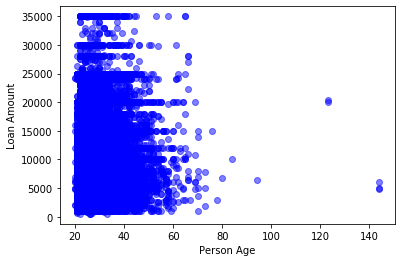

In [12]:
cr_loan = cr_loan_new

# Create the scatter plot for age and amount
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

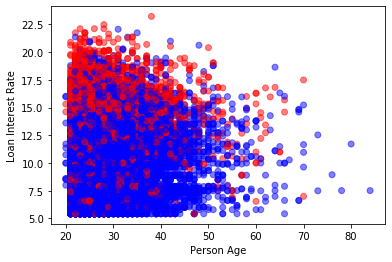

In [13]:
import matplotlib

# Use Pandas to drop the record from the data frame and create a new one
cr_loan_new = cr_loan.drop(cr_loan[cr_loan['person_age'] > 100].index)

# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.scatter(cr_loan_new['person_age'], cr_loan_new['loan_int_rate'],
            c = cr_loan_new['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

### Missing data?

In [14]:
# Print an array of columns with null values
print(cr_loan.columns[cr_loan.isnull().any()])

Index(['person_emp_length', 'loan_int_rate'], dtype='object')


In [15]:
# Print the top five rows with nulls for employment length
print(cr_loan[cr_loan['person_emp_length'].isnull()].head())

     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
105        

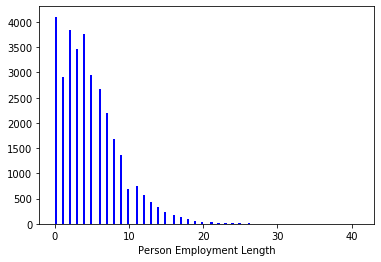

In [16]:
# Replace the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

### Removing missing data

I replaced missing data in person_emp_length, but I saw that loan_int_rate has missing data as well.

Similar to having missing data within loan_status, having missing data within loan_int_rate will make predictions difficult.

Because interest rates are set the company, having missing data in this column is very strange. It's possible that data ingestion issues created errors, but we cannot know for sure. For now, it's best to .drop() these records before moving forward.

In [17]:
# Print the number of nulls
print(cr_loan['loan_int_rate'].isnull().sum())

3116


In [18]:
# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)

cr_loan = cr_loan_clean

In [19]:
# Count the number of records for each unique value
cr_loan['person_home_ownership'].value_counts()

RENT        14892
MORTGAGE    12121
OWN          2356
OTHER          94
Name: person_home_ownership, dtype: int64

In [20]:
cr_loan

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [21]:
cr_loan.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [30]:
cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29463 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29463 non-null  int64  
 1   person_income               29463 non-null  int64  
 2   person_home_ownership       29463 non-null  object 
 3   person_emp_length           29463 non-null  float64
 4   loan_intent                 29463 non-null  object 
 5   loan_grade                  29463 non-null  object 
 6   loan_amnt                   29463 non-null  int64  
 7   loan_int_rate               29463 non-null  float64
 8   loan_status                 29463 non-null  int64  
 9   loan_percent_income         29463 non-null  float64
 10  cb_person_default_on_file   29463 non-null  object 
 11  cb_person_cred_hist_length  29463 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


In [22]:
exp_contin = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 
              'loan_percent_income', 'cb_person_cred_hist_length'
             ]

exp_nominal = ['person_home_ownership', 'loan_intent', 'loan_grade', 'loan_status', 
               'cb_person_default_on_file']